### RF 모델 성능이 유동적이라 Hyper Parameter tuning 진행 

In [1]:
## Import modules
from sklearn.ensemble import RandomForestClassifier as RFC 
from sklearn.tree import DecisionTreeClassifier as DTC 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

## Load Data
gganbu = pd.read_csv("../../../resources/processedData/깐부치킨_입지특성_모델_feature.csv", encoding='utf8')

In [8]:
## Prepare the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# set X,y
X = gganbu[["버스정류장 개수", "지하철역 개수",  "상업지역 비율","경쟁점 개수", "주거지역 비율", "인구수",  "유동인구비율"]]
y = gganbu["y"]

feature_name = ["버스정류장 개수", "지하철역 개수",  "상업지역 비율","경쟁점 개수", "주거지역 비율", "인구수",  "유동인구비율"]

# split into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

# Standardized data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### Tuning 할 Hyper Parameter 
- n_estimators(학습할 트리 모델 개수) - DT,RF
- max_depth(최대 깊이) - RF
- n_split(분리 노드의 최소 자료 수) - RF
- n_leaf(잎사귀 노드의 최소 자료수) - RF

In [9]:
## Plain model (tuning 안함)
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

In [35]:
# tuning 과정 시각화 함수
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.title(f"Hyper Parameter Tuning -: {algorithm_name} [{filename}]")
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    #plt.savefig('../figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장
    plt.show()

# n_estimators(학습할 트리 모델 개수) optimizer
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))
    
# max_depth(최대 깊이) optimizer
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

# n_split(분리 노드의 최소 자료 수) optimizer
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

# n_leaf(잎사귀 노드의 최소 자료수) optimizer
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

In [64]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['Red', 'White'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    #plt.savefig('../figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    #plt.savefig('../figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장

In [65]:
## RandomForest
algorithm = RFC
algorithm_name = 'RF'

In [66]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          X_train_std,
                                                          y_train,
                                                          X_test_std,
                                                          y_test)

학습 데이터셋 정확도: 1.0
테스트 데이터셋 정확도: 0.8


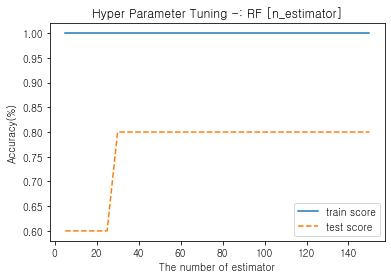

    n_estimators  TrainScore  TestScore
0              5         1.0        0.6
1             10         1.0        0.6
2             15         1.0        0.6
3             20         1.0        0.6
4             25         1.0        0.6
5             30         1.0        0.8
6             35         1.0        0.8
7             40         1.0        0.8
8             45         1.0        0.8
9             50         1.0        0.8
10            55         1.0        0.8
11            60         1.0        0.8
12            65         1.0        0.8
13            70         1.0        0.8
14            75         1.0        0.8
15            80         1.0        0.8
16            85         1.0        0.8
17            90         1.0        0.8
18            95         1.0        0.8
19           100         1.0        0.8
20           105         1.0        0.8
21           110         1.0        0.8
22           115         1.0        0.8
23           120         1.0        0.8


In [67]:
# n_estimator 갯수는 30 n_estimator = 30
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, 
                 X_train_std, y_train, X_test_std, y_test, 
                 n_estimator_min, n_estimator_max)

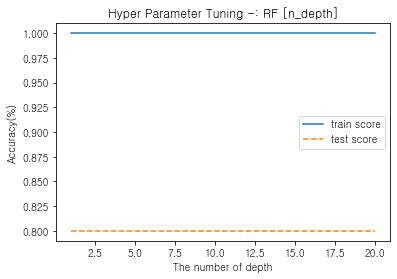

    depth  TrainScore  TestScore
0       1         1.0        0.8
1       2         1.0        0.8
2       3         1.0        0.8
3       4         1.0        0.8
4       5         1.0        0.8
5       6         1.0        0.8
6       7         1.0        0.8
7       8         1.0        0.8
8       9         1.0        0.8
9      10         1.0        0.8
10     11         1.0        0.8
11     12         1.0        0.8
12     13         1.0        0.8
13     14         1.0        0.8
14     15         1.0        0.8
15     16         1.0        0.8
16     17         1.0        0.8
17     18         1.0        0.8
18     19         1.0        0.8
19     20         1.0        0.8


In [43]:
n_estimator = 30
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm, algorithm_name, 
                X_train_std, y_train, X_test_std, y_test, 
                depth_min, depth_max, n_estimator)

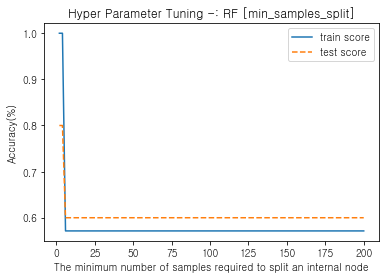

    min_samples_split  TrainScore  TestScore
0                   2      1.0000        0.8
1                   4      1.0000        0.8
2                   6      0.5714        0.6
3                   8      0.5714        0.6
4                  10      0.5714        0.6
5                  12      0.5714        0.6
6                  14      0.5714        0.6
7                  16      0.5714        0.6
8                  18      0.5714        0.6
9                  20      0.5714        0.6
10                 22      0.5714        0.6
11                 24      0.5714        0.6
12                 26      0.5714        0.6
13                 28      0.5714        0.6
14                 30      0.5714        0.6
15                 32      0.5714        0.6
16                 34      0.5714        0.6
17                 36      0.5714        0.6
18                 38      0.5714        0.6
19                 40      0.5714        0.6
20                 42      0.5714        0.6
21        

In [49]:
n_depth = 6
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 X_train_std, y_train, X_test_std, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

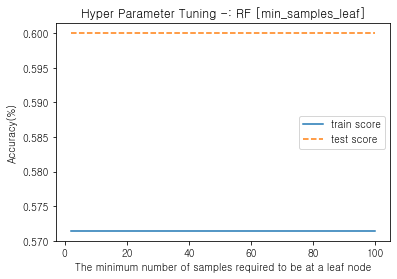

    min_samples_leaf  TrainScore  TestScore
0                  2      0.5714        0.6
1                  4      0.5714        0.6
2                  6      0.5714        0.6
3                  8      0.5714        0.6
4                 10      0.5714        0.6
5                 12      0.5714        0.6
6                 14      0.5714        0.6
7                 16      0.5714        0.6
8                 18      0.5714        0.6
9                 20      0.5714        0.6
10                22      0.5714        0.6
11                24      0.5714        0.6
12                26      0.5714        0.6
13                28      0.5714        0.6
14                30      0.5714        0.6
15                32      0.5714        0.6
16                34      0.5714        0.6
17                36      0.5714        0.6
18                38      0.5714        0.6
19                40      0.5714        0.6
20                42      0.5714        0.6
21                44      0.5714

In [59]:
n_split = 6
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               X_train_std, y_train, X_test_std, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

Accuracy: 0.600
Precision: 0.600
Recall: 1.000
F1-score: 0.750


c:\Users\dksle\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 2160x2160 with 0 Axes>

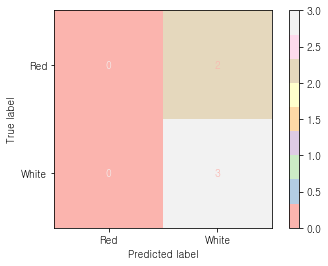

    Feature  Importance
0  버스정류장 개수        0.25
2   상업지역 비율        0.25
4   주거지역 비율        0.25
6    유동인구비율        0.25
1   지하철역 개수        0.00
3    경쟁점 개수        0.00
5       인구수        0.00


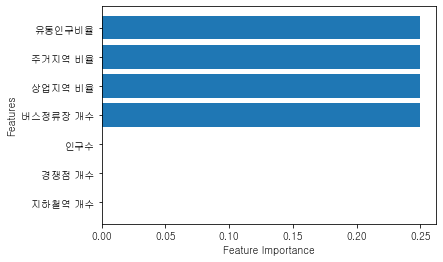

In [68]:
n_leaf = 2
model_final(algorithm, algorithm_name, feature_name,
            X_train_std, y_train, X_test_std, y_test,
            n_estimator, n_depth, n_split, n_leaf)